In [1]:
# Importing ML and python Libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from PIL import Image

# Importing Deep Learning Libraries 
import torch
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split, Dataset, ConcatDataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

### Functions

In [3]:
def read_images_from_folder(folder_path):
    """
    Reads images from a folder and creates a Pandas DataFrame.
    """
    images = []
    labels = []

    class_names = sorted(os.listdir(folder_path))

    for class_idx, class_name in enumerate(class_names):
        class_dir = os.path.join(folder_path, class_name)
        for filename in os.listdir(class_dir):
            img_path = os.path.join(class_dir, filename)
            image = Image.open(img_path)
            image = image.convert('RGB')
            images.append(image)
            labels.append(class_idx)

    # Create a DataFrame
    df = pd.DataFrame({'image': images, 'label': labels})
    return df

In [4]:
def print_label_count_df(df):
    """
    Visualizes label distribution in DataFrame as barplot.
    """
    # Count occurrences of each item
    labels = np.array(df['label'])
    unique_items, counts = np.unique(labels, return_counts=True)
    plt.bar(unique_items, counts)
    
    # Add labels and title
    plt.xlabel('Item')
    plt.ylabel('Count')
    plt.yticks(np.arange(counts.max()+1))
    plt.xticks(unique_items) 
    plt.title('Occurrence of Each Label in DataFrame')
    
    # Show plot
    plt.show()

In [5]:
def print_label_count(dataloader, classes):
    """
    Visualizes label distribution in a dataloader as a bar plot.
    """
    all_labels = []
    for _, labels in dataloader:
        all_labels.extend(labels.numpy())  # Accumulate labels from batches

    unique_labels, counts = np.unique(all_labels, return_counts=True)

    plt.bar(unique_labels, counts)

    # Add labels and title
    plt.xlabel('Label')
    plt.ylabel('Count')
    plt.xticks(rotation=90)
    plt.xticks(unique_labels, [classes[i] for i in unique_labels])  # Label with class names
    plt.title('Label Distribution in Dataloader')

    # Show plot
    plt.show()


In [6]:
def count_images_and_classes(dataloader, classes):
    """
    Counts the number of images and occurrences of each class in a dataloader.
    """
    total_count = 0
    class_counts = {cls: 0 for cls in classes}

    for _, labels in dataloader:
        total_count += labels.size(0)  # Add batch size
        for label in labels:
            class_counts[classes[label]] += 1

    print(f"Total number of images: {total_count}")
    print("Class counts:")
    for cls, count in class_counts.items():
        print(f"{cls}: {count}")

In [7]:
def plot_image_samples(df, title="DataFrame", num_samples=3):
    """
    Plots image samples from a single DataFrame within one figure.
    """
    sample_indices = np.random.choice(len(df), num_samples)
    sample_images = [df['image'].iloc[i] for i in sample_indices]
    sample_labels = [df['label'].iloc[i] for i in sample_indices] 
    
    # display the images with their predicted and real labels
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
    for i, (image, real_label) in enumerate(zip(sample_images, sample_labels)):
        axes[i].imshow(image)
        axes[i].set_title(f"Label: {real_label} From: {title}")
        axes[i].axis("off")
    
    plt.tight_layout()
    plt.show()

In [8]:
def print_images(loader):
    """
    Takes a loader and print an image for each batch
    """
    def imshow(img):
        img = img / 2 + 0.5     
        npimg = img.numpy()
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        plt.show()
    
    # Get some random images
    dataiter = iter(loader)
    images, labels = next(dataiter)
    
    # Show images
    imshow(torchvision.utils.make_grid(images))

In [9]:
# Creating custom dataset class for transforming dataframes to datasets
class CustomImageDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.img_labels = df['label']
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        image = self.df['image'].iloc[idx]  
        label = self.df['label'].iloc[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

### Reading data and transforming to Dataset

In [10]:
# Path to the folder containing images
folder_path = "raw-img"
# Create a dataframe from the folder
df = read_images_from_folder(folder_path)

In [11]:
classes = ["cane",
           "cavallo",
           "elefante",
           "farfalla",
           "gallina",
           "gatto", 
           "mucca",
          "pecora",
           "ragno",
           "scoiattolo"]

In [12]:
# 80% for train
# 10% for validation
# 10% for test

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
test_df, val_df = train_test_split(test_df, test_size=0.5, random_state=42)

In [13]:
# define transformations for data augmentation

transform_original = transforms.Compose([
    transforms.Resize((224, 224)),  # resize images to 224x224
    transforms.ToTensor(),  # convert images to PyTorch tensors
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # normalize the images
])

train_transform1 = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_transform2 = transforms.Compose([
    transforms.Resize((224, 224)),  # Example transformation
    transforms.RandomRotation(degrees=(-20, 20)),  # Example transformation
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_transform3 = transforms.Compose([
    transforms.Resize((224, 224)),  # Example transformation
    transforms.ColorJitter(contrast=0.2),  # Example transformation
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

After trying different variations I get the best accuracy with concatinating different augmented images for train set.

In [14]:
# Create multiple dataset with different techniques for train data
dataset1 = CustomImageDataset(train_df, transform=train_transform1)
dataset2 = CustomImageDataset(train_df, transform=train_transform2)
dataset3 = CustomImageDataset(train_df, transform=train_transform3)
dataset_org = CustomImageDataset(train_df, transform=transform_original)
trainset = ConcatDataset([dataset_org,dataset1, dataset2, dataset3])

In [15]:
# Define batch size and other DataLoader parameters
batch_size = 32
shuffle = True
num_workers = 2

# Create a DataLoader from the dataset
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=shuffle)

In [16]:
testset = CustomImageDataset(test_df, transform=transform_original)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=shuffle)

In [17]:
valset = CustomImageDataset(val_df, transform=transform_original)
valloader = DataLoader(valset, batch_size=batch_size, shuffle=shuffle)

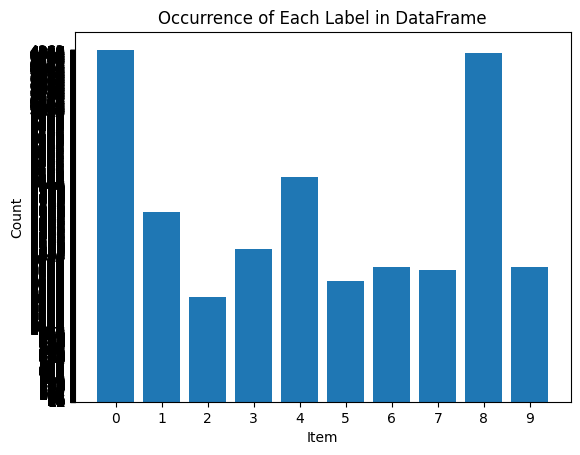

In [18]:
print_label_count_df(df)

-----------------THE IMAGE COUNT FOR TRAIN SET-----------------
Total number of images: 83772
Class counts:
cane: 15508
cavallo: 8404
elefante: 4556
farfalla: 6768
gallina: 9984
gatto: 5340
mucca: 6160
pecora: 5760
ragno: 15400
scoiattolo: 5892


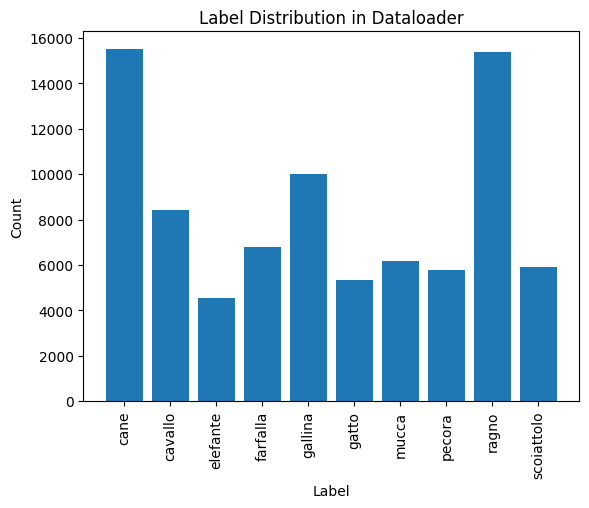

-----------------THE IMAGE COUNT FOR VALIDATION SET-----------------
Total number of images: 2618
Class counts:
cane: 500
cavallo: 250
elefante: 171
farfalla: 193
gallina: 299
gatto: 170
mucca: 157
pecora: 173
ragno: 504
scoiattolo: 201


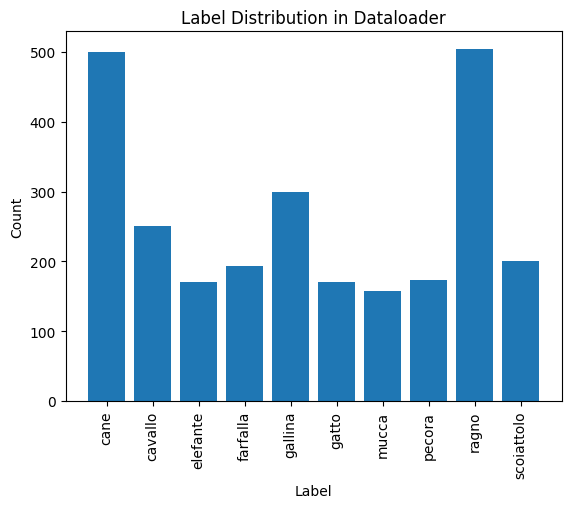

-----------------THE IMAGE COUNT FOR TEST SET-----------------
Total number of images: 2618
Class counts:
cane: 486
cavallo: 272
elefante: 136
farfalla: 227
gallina: 303
gatto: 163
mucca: 169
pecora: 207
ragno: 467
scoiattolo: 188


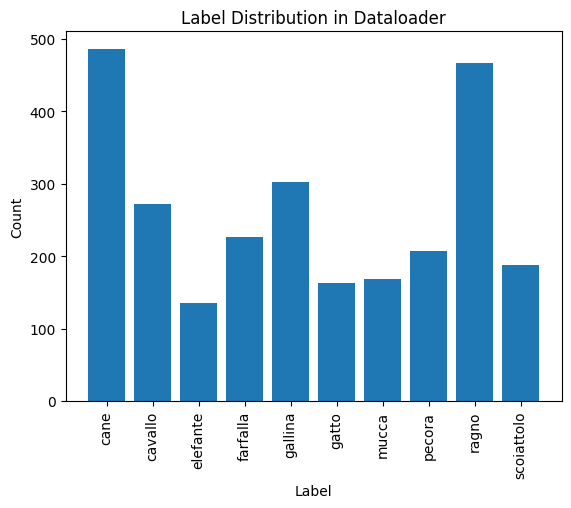

In [19]:
print("-----------------THE IMAGE COUNT FOR TRAIN SET-----------------")
count_images_and_classes(trainloader, classes)
print_label_count(trainloader, classes)
print("-----------------THE IMAGE COUNT FOR VALIDATION SET-----------------")
count_images_and_classes(valloader, classes)
print_label_count(valloader, classes)
print("-----------------THE IMAGE COUNT FOR TEST SET-----------------")
count_images_and_classes(testloader, classes)
print_label_count(testloader, classes)

### Building the CNN
#### Architecture Overview:
The architecture follows a common CNN pattern of stacking convolutional layers for feature extraction followed by fully connected layers for classification. The network consists of six convolutional layers (conv1 to conv6), each followed by ReLU activation and max pooling. The final feature map is flattened and passed through two fully connected layers (fc1 and fc2) to produce class probabilities.
##### Layer Details:
###### Convolutional Layers:
- Use 3x3 kernels with padding to maintain spatial dimensions.
- The number of filters increases with depth (16, 32, 64, 128, 256, 512) to extract progressively more complex features.
###### Max Pooling:
- 2x2 pooling layers are applied after each convolutional layer to reduce spatial dimensions and prevent overfitting.
###### Fully Connected Layers:
- fc1 maps the flattened features to a 128-dimensional space.
- fc2 produces the final output with 10 dimensions (for 10 classes).

In [20]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
       # Convolutional layers with ReLU activation
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(256, 512, kernel_size=3, padding=1)

        # Max pooling layer
        self.pool = nn.MaxPool2d(2, 2)

        # Fully connected layers with ReLU activation
        self.fc1 = nn.Linear(512 * 3 * 3, 128)  
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = self.pool(F.relu(self.conv5(x)))
        x = self.pool(F.relu(self.conv6(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch      
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [21]:
net = Net()
print("-------------DETAILS OF CNN ARCHITECHTURE-------------")
print(net.to(device)) # for GPU

-------------DETAILS OF CNN ARCHITECHTURE-------------
Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4608, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


Used Cross Entropy Loss since this is the most common loss function for image classification tasks. It measures the difference between the predicted probability distribution and the true class label.
As optimizer used Adam with 0.0001 learning rate.

#### Best Model

In [22]:
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [23]:
# lists to store loss and accuracy for each epoch
epoch_size = 100 # given in instructions

epoch_losses = []
epoch_accuracies = []

for epoch in range(epoch_size):  # loop over the dataset multiple times

    running_loss = 0.0
    correct = 0
    total = 0
    
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device) #for GPU

        # zero the parameter gradients for no gradient accumulation
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = loss_func(outputs, labels)
        loss.backward()
        optimizer.step()

        # calculate running loss
        running_loss += loss.item()
        # Calculate running accuracy (assuming you have a function `get_accuracy`)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Store epoch loss and accuracy
    epoch_loss = running_loss / len(trainloader)
    epoch_accuracy = 100 * correct / total
    epoch_losses.append(epoch_loss)
    epoch_accuracies.append(epoch_accuracy)
        
    print(f'Epoch [{epoch+1}/{epoch_size}] loss: {epoch_loss:.3f}, accuracy: {epoch_accuracy:.3f}%')


print('Finished Training')

Epoch [1/100] loss: 1.359, accuracy: 52.925%
Epoch [2/100] loss: 0.718, accuracy: 75.808%
Epoch [3/100] loss: 0.433, accuracy: 85.501%
Epoch [4/100] loss: 0.305, accuracy: 90.183%
Epoch [5/100] loss: 0.247, accuracy: 92.175%
Epoch [6/100] loss: 0.210, accuracy: 93.285%
Epoch [7/100] loss: 0.189, accuracy: 94.061%
Epoch [8/100] loss: 0.180, accuracy: 94.348%
Epoch [9/100] loss: 0.161, accuracy: 94.908%
Epoch [10/100] loss: 0.156, accuracy: 95.096%
Epoch [11/100] loss: 0.145, accuracy: 95.362%
Epoch [12/100] loss: 0.145, accuracy: 95.415%
Epoch [13/100] loss: 0.138, accuracy: 95.593%
Epoch [14/100] loss: 0.132, accuracy: 95.923%
Epoch [15/100] loss: 0.130, accuracy: 95.896%
Epoch [16/100] loss: 0.127, accuracy: 96.023%
Epoch [17/100] loss: 0.126, accuracy: 96.083%
Epoch [18/100] loss: 0.118, accuracy: 96.283%
Epoch [19/100] loss: 0.118, accuracy: 96.427%
Epoch [20/100] loss: 0.116, accuracy: 96.370%
Epoch [21/100] loss: 0.112, accuracy: 96.560%
Epoch [22/100] loss: 0.110, accuracy: 96.68

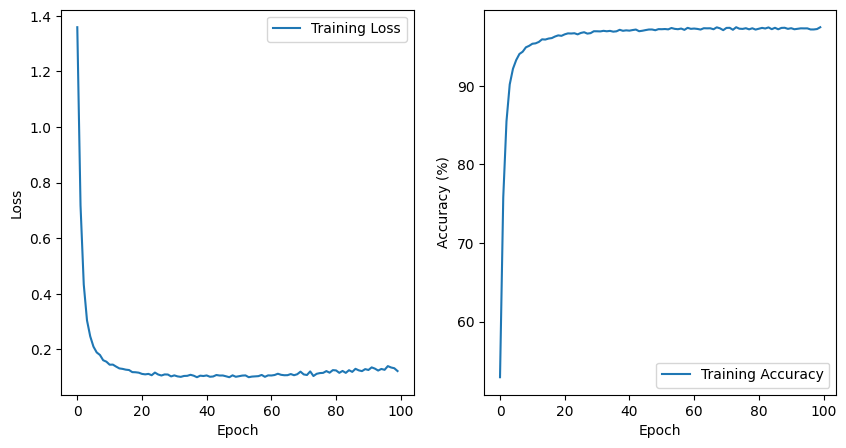

Finished Training


In [24]:
# Plotting after training
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epoch_losses, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epoch_accuracies, label="Training Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()

plt.show()

print('Finished Training')

In [25]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in valloader:
        images, labels = data[0].to(device), data[1].to(device) # for GPU
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the validation images: {100 * correct // total} %')

Accuracy of the network on the validation images: 78 %


In [26]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in valloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    try:
        accuracy = 100 * float(correct_count) / total_pred[classname]
        print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')
    except:
        print("hata")

Accuracy for class: cane  is 82.4 %
Accuracy for class: cavallo is 74.4 %
Accuracy for class: elefante is 66.7 %
Accuracy for class: farfalla is 83.4 %
Accuracy for class: gallina is 84.3 %
Accuracy for class: gatto is 67.1 %
Accuracy for class: mucca is 72.0 %
Accuracy for class: pecora is 59.0 %
Accuracy for class: ragno is 86.7 %
Accuracy for class: scoiattolo is 76.6 %


In [27]:
PATH = './compvis3vers1.3.pth'
torch.save(net.state_dict(), PATH)

### Transfer Learning With EfficientNet B0


In [ ]:
model = models.efficientnet_b0(weights='DEFAULT')
for param in model.parameters():
    param.requires_grad = False
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, 10)

In [ ]:
model = model.to(device)

In [ ]:
loss_func = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
# lists to store loss and accuracy for each epoch

epoch_losses = []
epoch_accuracies = []

for epoch in range(epoch_size):  # loop over the dataset multiple times

    running_loss = 0.0
    correct = 0
    total = 0
    
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device) #for GPU

        # zero the parameter gradients for no gradient accumulation
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = loss_func(outputs, labels)
        loss.backward()
        optimizer.step()

        # calculate running loss
        running_loss += loss.item()
        # Calculate running accuracy (assuming you have a function `get_accuracy`)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Store epoch loss and accuracy
    epoch_loss = running_loss / len(trainloader)
    epoch_accuracy = 100 * correct / total
    epoch_losses.append(epoch_loss)
    epoch_accuracies.append(epoch_accuracy)
        
    print(f'Epoch [{epoch+1}/{epoch_size}] loss: {epoch_loss:.3f}, accuracy: {epoch_accuracy:.3f}%')


print('Finished Training')

In [ ]:
# Plotting after training
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epoch_losses, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epoch_accuracies, label="Training Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()

plt.show()

print('Finished Training')

In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in valloader:
        images, labels = data[0].to(device), data[1].to(device) # for GPU
        # calculate outputs by running images through the network
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the validation images: {100 * correct // total} %')